In [1]:
import time
start = time.time()
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import os

Seed değerimi giriyorum

In [2]:
torch.manual_seed(190401015)

MLP için class oluşturuyoruz.

Creating new class for MLP

In [3]:
class MLP(nn.Module):
    def __init__(self, insize, hidden1, hidden2, outputsize):
        super(MLP, self).__init__()
        self.hidden_layer1 = nn.Linear(insize, hidden1)
        self.hidden_layer2 = nn.Linear(hidden1, hidden2)
        self.output_layer = nn.Linear(hidden2, outputsize)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output = self.relu(self.hidden_layer1(x))
        output = self.relu(self.hidden_layer2(output))
        output = self.sigmoid(self.output_layer(output))
        return output

csv verimizi okuma 

reading the csv file

In [4]:
training_data = pd.read_csv("./cure_the_princess_train.csv")
val_data = pd.read_csv("./cure_the_princess_validation.csv")
test_data = pd.read_csv("./cure_the_princess_test.csv")
labels = training_data.columns.tolist()
num_of_classes = len(labels)
train_x = training_data.iloc[:, :-1].values
train_y = training_data.iloc[:, -1].values
val_x = val_data.iloc[:, :-1].values
val_y = val_data.iloc[:, -1].values
test_x = test_data.iloc[:, :-1].values
test_y = test_data.iloc[:, -1].values

CustomData adında class oluşturup okunan verilerimizi işleme

Creating new class called CustomData for using our data

In [5]:
class CustomData(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_data = CustomData(train_x, train_y)
validation_data = CustomData(val_x, val_y)
test_data = CustomData(test_x, test_y)

In [6]:
learning_rate = 0.00167
epochnum = 200
bsize = 16
insize = 13
hidden1 = 100
hidden2 = 50
outsize = 1
patience = 10

In [7]:
model = MLP(insize, hidden1, hidden2, outsize)

In [8]:
# Loss fonksiyonunu belirlemek / Determining loss function
criterion = nn.BCELoss()

# Optimizer'ı belirlemek / Determining optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=bsize, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_data, batch_size=bsize, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=bsize, shuffle=False)

In [10]:
train_loss_list = []
valid_loss_list = []

In [11]:
patience_counter = 0
best_value_loss = None
for epoch in range(epochnum):
    train_loss = 0.0
    train_count = 0.0
    valid_loss = 0.0

    # Eğitim verileri üzerinde eğitim yapmak / Training
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        train_count += 1
        train_loss += loss.item()

    # Doğrulama verileri üzerinde test yapmak / Testing
    with torch.no_grad():
        model.eval()
        for data, target in valid_loader:
            output = model(data)
            loss = criterion(output, target.unsqueeze(1).float())
            valid_loss += loss.item()
    
    model.train()
    # Loss değerlerini kaydetmek / Saving the Loss values
    train_loss = train_loss / train_count
    valid_loss = valid_loss / len(valid_loader)
        
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch + 1, train_loss, valid_loss))
    
    val_score = valid_loss
    if best_value_loss is None:
        best_value_loss = val_score # hafızada patience boyu tutmaya başla
        torch.save(model.state_dict(), "checkpoint.pt")
    elif best_value_loss < val_score: # patience counter
        patience_counter = patience_counter + 1
        print("Earlystopping Patience Counter:",patience_counter)
        if patience_counter == patience:
            break
    else:
        best_value_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt") # to keep the best model
        patience_counter = 0

Epoch: 1 	Training Loss: 0.679726 	Validation Loss: 0.594903
Epoch: 2 	Training Loss: 0.582686 	Validation Loss: 0.514434
Epoch: 3 	Training Loss: 0.525498 	Validation Loss: 0.458775
Epoch: 4 	Training Loss: 0.484742 	Validation Loss: 0.419505
Epoch: 5 	Training Loss: 0.445706 	Validation Loss: 0.401848
Epoch: 6 	Training Loss: 0.419666 	Validation Loss: 0.356211
Epoch: 7 	Training Loss: 0.395933 	Validation Loss: 0.333594
Epoch: 8 	Training Loss: 0.375798 	Validation Loss: 0.318667
Epoch: 9 	Training Loss: 0.352688 	Validation Loss: 0.334290
Earlystopping Patience Counter: 1
Epoch: 10 	Training Loss: 0.336368 	Validation Loss: 0.298473
Epoch: 11 	Training Loss: 0.326899 	Validation Loss: 0.296004
Epoch: 12 	Training Loss: 0.314086 	Validation Loss: 0.272447
Epoch: 13 	Training Loss: 0.304173 	Validation Loss: 0.265857
Epoch: 14 	Training Loss: 0.294756 	Validation Loss: 0.336482
Earlystopping Patience Counter: 1
Epoch: 15 	Training Loss: 0.285755 	Validation Loss: 0.308048
Earlystoppi

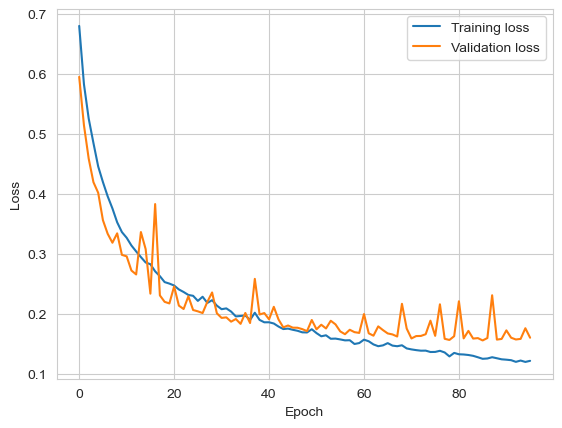

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.plot(train_loss_list, label="Training loss")
plt.plot(valid_loss_list, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

model.load_state_dict(torch.load('checkpoint.pt'))

preds = []
tlabels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = torch.round(outputs)
        preds.extend(predicted.detach().cpu().numpy())
        tlabels.extend(labels.detach().cpu().numpy())

accuracy = accuracy_score(tlabels, preds)
f1 = f1_score(tlabels, preds)
precision = precision_score(tlabels, preds)
recall = recall_score(tlabels, preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Accuracy: 0.9482
F1 score: 0.9471
Precision: 0.9728
Recall: 0.9227


In [14]:
end = time.time()
elapsed = end - start
print("Elapsed:", f'{elapsed:.2f}', "secs")

Elapsed: 2.93 secs
